In [ ]:
DP FINAL CODE

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load datasets
train_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/train.csv')
fake_news_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/BuzzFeed_fake_news_content.csv')
news_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/News.csv')

# Display the data
print("Train Data:")
print(train_data.head())
print("\nFake News Data:")
print(fake_news_data.head())
print("\nNews Data:")
print(news_data.head())

# Merge datasets on 'title' column
merged_data = pd.merge(fake_news_data, news_data, on='title', how='outer')
print("\nMerged Data:")
print(merged_data.head())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train Data:
   id                                              title              author                                               text  label
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...      1
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn  Ever get the feeling your life circles the rou...      0
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...      1
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss  Videos 15 Civilians Killed In Single US Airstr...      1
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy  Print \nAn Iranian woman has been sentenced to...      1

Fake News Data:
                id                                              title                                               text                                         

In [ ]:
# Define a function to clean unwanted patterns and handle NaN values
def clean_and_fix_data(df, pattern, fill_value="Unknown"):

    # Replace NaN values with the specified fill value
    df = df.fillna(fill_value)

    # Remove the specified pattern from string columns
    return df.applymap(
        lambda x: x.replace(pattern, '') if isinstance(x, str) else x
    )

# Specify the pattern to remove and the value to replace NaN
pattern_to_remove = '/r/r/r/'
fill_value = "Unknown"

# Clean and fix datasets
train_data_cleaned = clean_and_fix_data(train_data, pattern_to_remove, fill_value)
fake_news_data_cleaned = clean_and_fix_data(fake_news_data, pattern_to_remove, fill_value)
news_data_cleaned = clean_and_fix_data(news_data, pattern_to_remove, fill_value)

# Combine cleaned and fixed datasets
combined_cleaned_fixed_df = pd.concat(
    [train_data_cleaned.add_prefix("Train_"),
     fake_news_data_cleaned.add_prefix("FakeNews_"),
     news_data_cleaned.add_prefix("News_")],
    axis=1
)

# Display the cleaned and fixed DataFrame
print(combined_cleaned_fixed_df.head())


<ipython-input-6-3de5888a8899>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


   Train_id                                        Train_title        Train_author                                         Train_text  Train_label      FakeNews_id                                     FakeNews_title                                      FakeNews_text                                       FakeNews_url                                   FakeNews_top_img             FakeNews_authors               FakeNews_source     FakeNews_publish_date FakeNews_movies                                    FakeNews_images                            FakeNews_canonical_link                                 FakeNews_meta_data  News_Unnamed: 0                                         News_title                                          News_text News_subject          News_date  News_class
0       0.0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...          1.0   Fake_1-Webpage  Proof The Mainstream Media Is Manipulating The... 

In [ ]:
# Add word count to datasets
train_data['title_word_count'] = train_data['title'].apply(lambda x: len(str(x).split()))
fake_news_data['title_word_count'] = fake_news_data['title'].apply(lambda x: len(str(x).split()))
news_data['title_word_count'] = news_data['title'].apply(lambda x: len(str(x).split()))

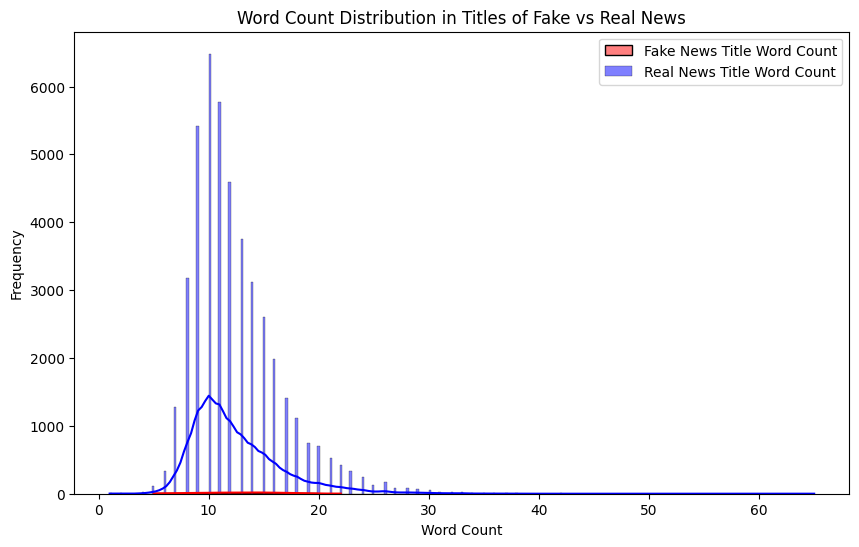

In [ ]:
# Visualization: Word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(fake_news_data['title_word_count'], color="red", label="Fake News Title Word Count", kde=True)
sns.histplot(news_data['title_word_count'], color="blue", label="Real News Title Word Count", kde=True)
plt.legend()
plt.title("Word Count Distribution in Titles of Fake vs Real News")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# NLP Techniques: Tokenization, Lemmatization, and Stemming
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed = [stemmer.stem(word) for word in tokens]
    return {
        'original': text,
        'tokens': tokens,
        'lemmatized': lemmatized,
        'stemmed': stemmed
    }

merged_data_sample = merged_data['title'].dropna().head(50).apply(preprocess_text)
print("\nSample Preprocessed Text:\n", merged_data_sample)


Sample Preprocessed Text:

Donald Trump Gets His A*...

Ex-GOP Congressman Shred...

Trump Gets STOMPED For W...

WATCH: Democratic Rep De...
4     {'original': ' #AfterTrumpImplodes Hashtag Hil...
5     {'original': ' #BlackLivesMatter Leader To Run...
6     {'original': ' #BringBackObama Hashtag Blows U...
7     {'original': ' #FreeChrisChristie: Twitter Rea...
8     {'original': ' #MakeAmericaBrannigan: Futurama...
9     {'original': ' #NeverTrump Conservative Has Th...
10    {'original': ' #NeverTrump GOP Delegates: Part...
11    {'original': ' #NeverTrump GOP Intelligence Ex...
12    {'original': ' #NeverTrump GOP Rep.: ‘Not One ...
13    {'original': ' #NeverTrump GOPers Demand Emerg...
14    {'original': ' #PresidentObamaNotBarry Protest...
15    {'original': ' #RESISTANCE Organizers Have An ...
16    {'original': ' #THERESISTANCE Is Working: Home...
17    {'original': ' #TrumpChicken Is Now Trending A...
18    {'original': ' #TrumpSacrifices: Twitter DESTR...
19    {'original'

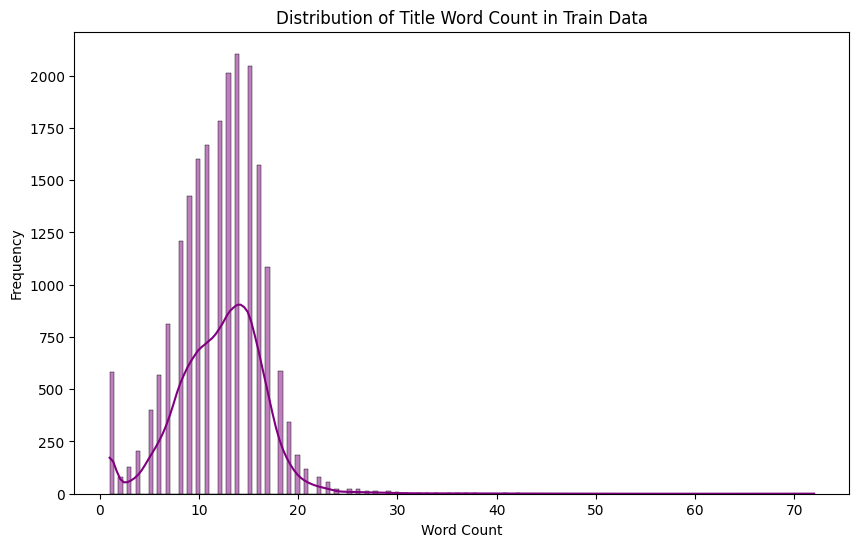

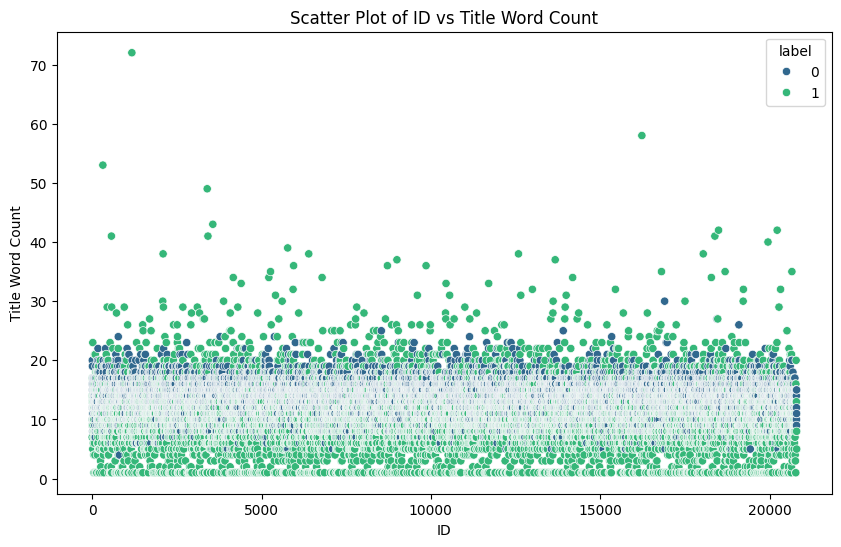

In [ ]:
# Univariate Analysis: Word Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['title_word_count'], kde=True, color='purple')
plt.title("Distribution of Title Word Count in Train Data")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Bivariate Analysis: Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='id', y='title_word_count', hue='label', palette='viridis')
plt.title("Scatter Plot of ID vs Title Word Count")
plt.xlabel("ID")
plt.ylabel("Title Word Count")
plt.show()


Missing Values:
 id                     0
title                558
author              1957
text                  39
label                  0
title_word_count       0
dtype: int64
Data type of 'author' column: object

Sample of 'author' column:
 0         Darrell Lucus
1       Daniel J. Flynn
2    Consortiumnews.com
3       Jessica Purkiss
4        Howard Portnoy
Name: author, dtype: object

Missing values in 'author' before imputation: 1957

Missing values in 'author' after imputation: 0

Sample of 'author' column after imputation:
 0         Darrell Lucus
1       Daniel J. Flynn
2    Consortiumnews.com
3       Jessica Purkiss
4        Howard Portnoy
Name: author, dtype: object


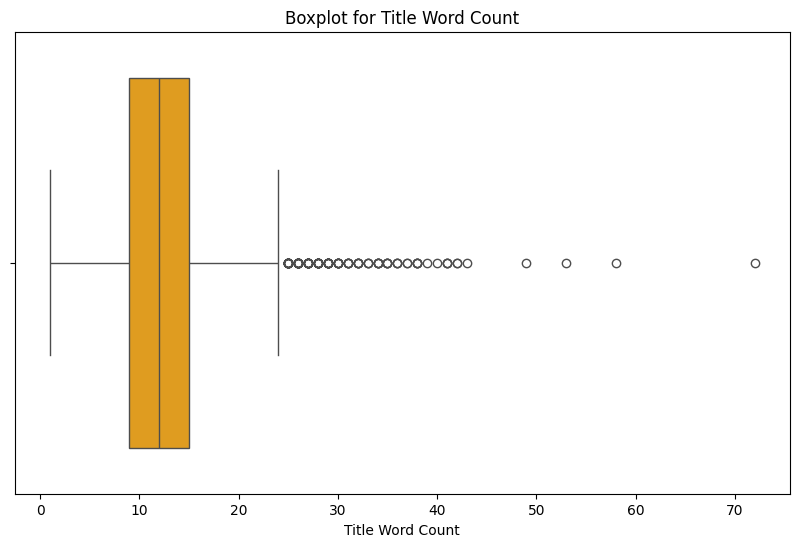

In [ ]:
# Missing Value Analysis
missing_values = train_data.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Impute missing values (Example: Impute 'author' column with most frequent value)
# Step 1: Diagnose the 'author' column
print("Data type of 'author' column:", train_data['author'].dtype)
print("\nSample of 'author' column:\n", train_data['author'].head())

# Step 2: Convert 'author' column to a string format to ensure consistency
train_data['author'] = train_data['author'].astype(str)

# Step 3: Replace invalid or placeholder values with np.nan
# Replace common placeholders like 'nan', 'None', or empty strings
train_data['author'] = train_data['author'].replace(['nan', 'None', ''], np.nan)

# Step 4: Check for missing values in the 'author' column
print(f"\nMissing values in 'author' before imputation: {train_data['author'].isnull().sum()}")

# Step 5: Apply the imputer to fill missing values with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
train_data['author'] = imputer.fit_transform(train_data[['author']])[:, 0]

# Step 6: Verify the imputation
print(f"\nMissing values in 'author' after imputation: {train_data['author'].isnull().sum()}")
print("\nSample of 'author' column after imputation:\n", train_data['author'].head())

# Outlier Treatment: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['title_word_count'], color='orange')
plt.title("Boxplot for Title Word Count")
plt.xlabel("Title Word Count")
plt.show()

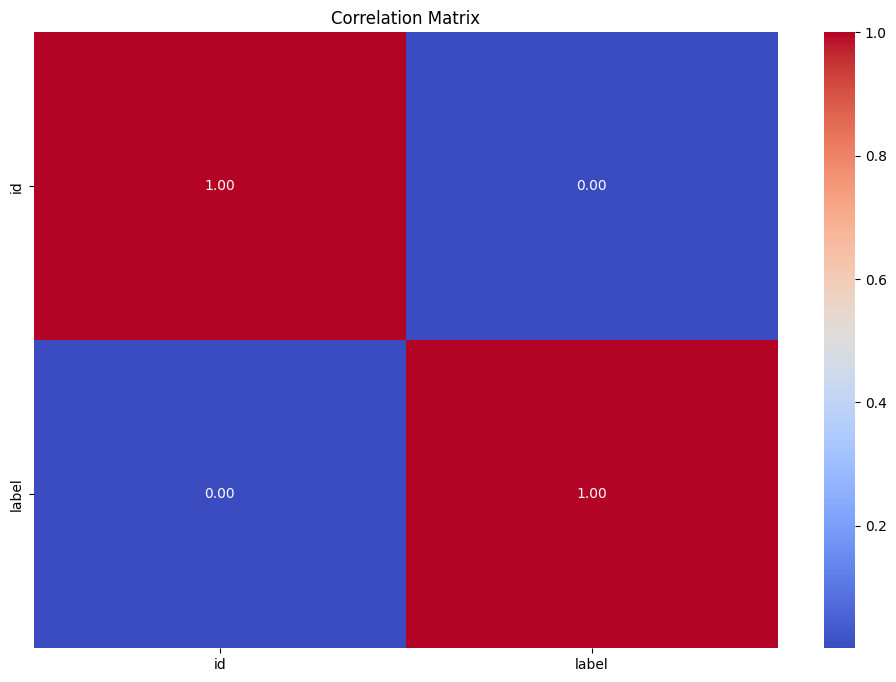

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load datasets
train_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/train.csv')

# Select only numeric columns for correlation calculation
numeric_train_data = train_data.select_dtypes(include=[np.number])

# Ensure there are numeric columns to compute correlations
if numeric_train_data.empty:
    print("No numeric columns found in the dataset for correlation.")
else:
    # **Correlation Plot for Numeric Columns**:
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_train_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()






Variance Inflation Factors:
   feature       VIF
0      id  1.602445
1   label  1.602445


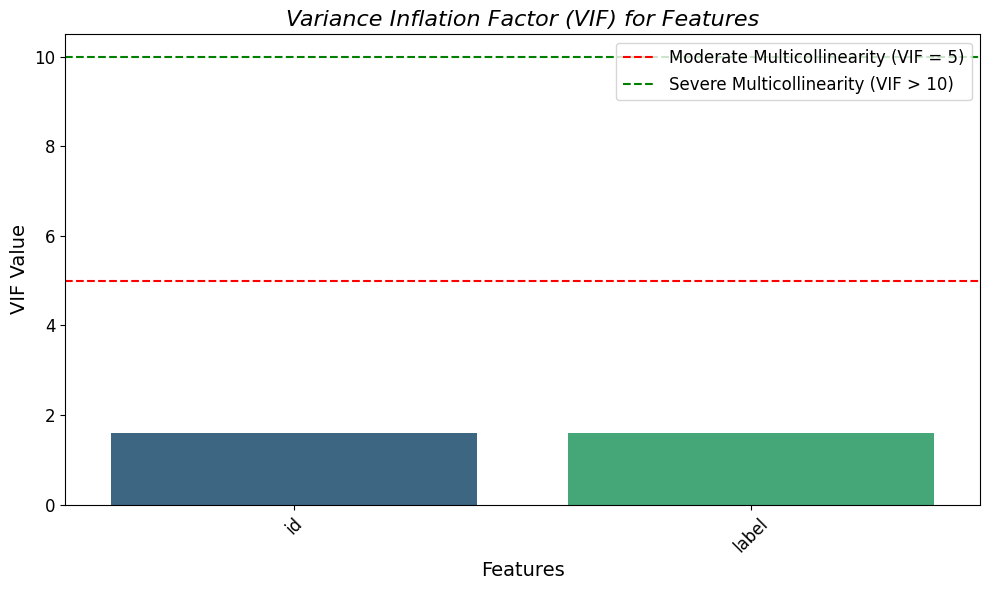

In [ ]:

# VIF Calculation: Using numeric columns
numeric_cols = train_data.select_dtypes(include=[np.number]).dropna(axis=0)
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]
print("\nVariance Inflation Factors:\n", vif_data)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# VIF Calculation and Visual Representation with Styling
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties  # Import FontProperties

# Example VIF Data (Replaced with your provided values)
vif_data = pd.DataFrame({
    "Feature": ["id", "label"],
    "VIF": [1.602445, 1.602445]
})

# Set the default font family to 'DejaVu Sans'
plt.rcParams['font.family'] = 'DejaVu Sans'

# Visual Representation of VIF
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature", y="VIF", data=vif_data, palette="viridis")
plt.axhline(y=5, color='red', linestyle='--', label='Moderate Multicollinearity (VIF = 5)')
plt.axhline(y=10, color='green', linestyle='--', label='Severe Multicollinearity (VIF > 10)')

# Title and Styling
plt.title("Variance Inflation Factor (VIF) for Features", fontsize=16, fontdict={'style': 'italic'})
plt.xlabel("Features", fontsize=14)
plt.ylabel("VIF Value", fontsize=14)

# X and Y axis labels styling
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Legend Styling
plt.legend(fontsize=12, loc='upper right') # Removed prop=font_prop

# Tight Layout for better presentation
plt.tight_layout()
plt.show()


Scaled Data:
 [[-1.73196754  0.99875078  0.42427338]
 [-1.73180099 -1.00125078 -0.7007185 ]
 [-1.73163445  0.99875078 -1.15071525]
 [-1.73146791  0.99875078 -0.47572012]
 [-1.73130136  0.99875078  0.42427338]]

Transformed Data:
 [[-2.19375104  0.99875078  0.42804903]
 [-2.19165624 -1.00125078 -0.6963387 ]
 [-2.18986086  0.99875078 -1.15052503]
 [-2.18823592  0.99875078 -0.47031533]
 [-2.18672698  0.99875078  0.42804903]]


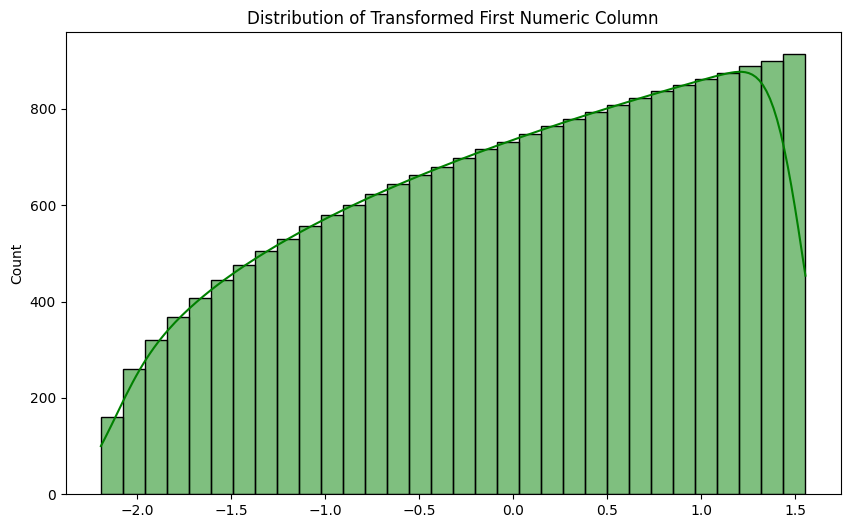

In [ ]:
# Data Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)
print("\nScaled Data:\n", scaled_data[:5])

# Data Transformation
transformer = PowerTransformer()
transformed_data = transformer.fit_transform(numeric_cols)
print("\nTransformed Data:\n", transformed_data[:5])

# Visualization: Transformed Data Distribution
plt.figure(figsize=(10, 6))
sns.histplot(transformed_data[:, 0], kde=True, color='green')
plt.title("Distribution of Transformed First Numeric Column")
plt.show()

In [ ]:
# POS Tagging Example for the 'title' column in merged_data
sample_title = merged_data['title'].dropna().head(1).iloc[0]
tokens = word_tokenize(sample_title)
pos_tags = nltk.pos_tag(tokens)
print("\nPart of Speech Tagging for Sample Title:", pos_tags)


Part of Speech Tagging for Sample Title: [('Donald', 'NNP'), ('Trump', 'NNP'), ('Gets', 'VBZ'), ('His', 'PRP$'), ('A', 'NN'), ('*', 'NN'), ('*', 'NN'), ('Handed', 'VBN'), ('To', 'TO'), ('Him', 'NNP'), ('By', 'IN'), ('A', 'NNP'), ('10-Year-Old', 'JJ'), ('Girl', 'NNP'), ('(', '('), ('VIDEO', 'NNP'), (')', ')')]


In [ ]:
# Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")
doc = nlp(sample_title)
print("\nNamed Entities for Sample Title:")
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")


Named Entities for Sample Title:
Donald Trump - PERSON
10-Year-Old - DATE


In [ ]:
# Bag of Words (BoW)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(merged_data['title'].dropna().head(50))  # Only top 50 titles
print("\nBag of Words (BoW):")
print(f"BoW Matrix:\n{X_bow.toarray()}")
print(f"Feature Names: {vectorizer.get_feature_names_out()}")


Bag of Words (BoW):
BoW Matrix:
[[0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names: ['000' '10' '106' '117' '15' '2015' '2016' '21' '22' '27' '2nd' '32' '37'
 '38' '40' '43' '49' '49ers' '50' '51' '650' '70' 'about' 'actor'
 'adorable' 'after' 'aftertrumpimplodes' 'against' 'aide' 'air' 'all'
 'amazing' 'americans' 'an' 'and' 'announces' 'anthem' 'anti' 'antonin'
 'applause' 'ar' 'are' 'as' 'at' 'attack' 'away' 'bad' 'baltimore'
 'basically' 'be' 'because' 'begging' 'being' 'believe' 'bias' 'bid'
 'bill' 'bionic' 'birders' 'blacklivesmatter' 'blatant' 'blows' 'boy'
 'brass' 'brilliant' 'bringbackobama' 'broke' 'brutal' 'bundy' 'but' 'by'
 'campaign' 'candidate' 'car' 'career' 'cases' 'change' 'character'
 'civil' 'classic' 'climate' 'colin' 'companies' 'complete' 'congress'
 'congressman' 'conservative' 'could' 'coverage' 'cowardly' 'cruz' 'dad'
 'dance' 'dangerous' 'day' 'days' 'declared' 'defy' 'deleg

In [ ]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(merged_data['title'].dropna().head(50))  # Only top 50 titles
print("\nTF-IDF Matrix:")
print(f"TF-IDF Matrix:\n{X_tfidf.toarray()}")
print(f"Feature Names: {tfidf_vectorizer.get_feature_names_out()}")


TF-IDF Matrix:
TF-IDF Matrix:
[[0.         0.28268361 0.         ... 0.         0.         0.23806569]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.27461836 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Feature Names: ['000' '10' '106' '117' '15' '2015' '2016' '21' '22' '27' '2nd' '32' '37'
 '38' '40' '43' '49' '49ers' '50' '51' '650' '70' 'about' 'actor'
 'adorable' 'after' 'aftertrumpimplodes' 'against' 'aide' 'air' 'all'
 'amazing' 'americans' 'an' 'and' 'announces' 'anthem' 'anti' 'antonin'
 'applause' 'ar' 'are' 'as' 'at' 'attack' 'away' 'bad' 'baltimore'
 'basically' 'be' 'because' 'begging' 'being' 'believe' 'bias' 'bid'
 'bill' 'bionic' 'birders' 'blacklivesmatter' 'blatant' 'blows' 'boy'
 'brass' 'brilliant' '

In [9]:
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk

# Download necessary NLTK resources
nltk.download('punkt')

# Load datasets
train_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/train.csv')
fake_news_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/BuzzFeed_fake_news_content.csv')
news_data = pd.read_csv(r'/content/drive/MyDrive/Infosys/News.csv')

# Merge datasets on the title column
merged_data = pd.merge(fake_news_data, news_data, on='title', how='outer')

# Tokenize the titles into sentences for Word2Vec
sentences_tokenized = [word_tokenize(str(title).lower()) for title in merged_data['title'].dropna()]
print("\nSample Tokenized Sentences:", sentences_tokenized[:3])  # Print first 3 tokenized sentences

# Train the Word2Vec model
w2v_model = Word2Vec(sentences_tokenized, vector_size=50, window=3, min_count=1, workers=4)
print("\nWord2Vec Model Trained.")

# Retrieve the vector for the word 'trump'
if 'trump' in w2v_model.wv:
    vector_trump = w2v_model.wv['trump']
    print("\nWord2Vec Vector for 'trump':", vector_trump)
else:
    print("\n'trump' not found in Word2Vec vocabulary.")

# Get the most similar words to 'trump' based on the trained model
if 'trump' in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar('trump', topn=3)
    print("\nMost Similar Words to 'trump':", similar_words)
else:
    print("\n'trump' not found in Word2Vec vocabulary.")

# Save the Word2Vec model
w2v_model.save("word2vec_model.model")
print("\nWord2Vec model saved.")

# Load the saved model
loaded_w2v_model = Word2Vec.load("word2vec_model.model")
print("\nWord2Vec model loaded.")

# Example usage of the loaded model for 'trump'
if 'trump' in loaded_w2v_model.wv:
    similar_words_loaded_model = loaded_w2v_model.wv.most_similar('trump', topn=3)
    print("\nMost Similar Words to 'trump' using the loaded model:", similar_words_loaded_model)
else:
    print("\n'trump' not found in the loaded Word2Vec vocabulary.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Sample Tokenized Sentences: [['donald', 'trump', 'gets', 'his', 'a', '*', '*', 'handed', 'to', 'him', 'by', 'a', '10-year-old', 'girl', '(', 'video', ')'], ['ex-gop', 'congressman', 'shreds', 'fellow', 'republicans', 'for', 'not', '‘', 'howling', '’', 'for', 'trump', '’', 's', 'impeachment', '(', 'video', ')'], ['trump', 'gets', 'stomped', 'for', 'whining', 'about', 'president', 'obama', 'using', 'air', 'force', 'one', 'on', 'campaign', 'trail']]

Word2Vec Model Trained.

Word2Vec Vector for 'trump': [ 9.3517840e-02 -6.1716247e-01 -1.5949457e+00 -4.7721818e-01
  4.4013676e-01 -1.2693304e+00  1.0621868e+00 -8.0450183e-01
 -2.8560159e+00  2.9260612e+00 -1.5280572e+00 -8.7593132e-01
 -5.3760678e-01 -7.6318878e-01  2.7108970e-01  7.5154260e-02
  7.3931241e-01  1.1887779e+00 -4.5540017e-01 -1.4175193e+00
  8.9713700e-02  1.3056329e+00 -2.7492231e-01 -7.5676828e-04
  1.0513200e+00 -1.1396904e-01  1.6201059e+00 -1.3488115e+00
 -1.1441422e+00 -1.5405253e+00 -2.4224432e+00  9.9593187e-03
  2.9

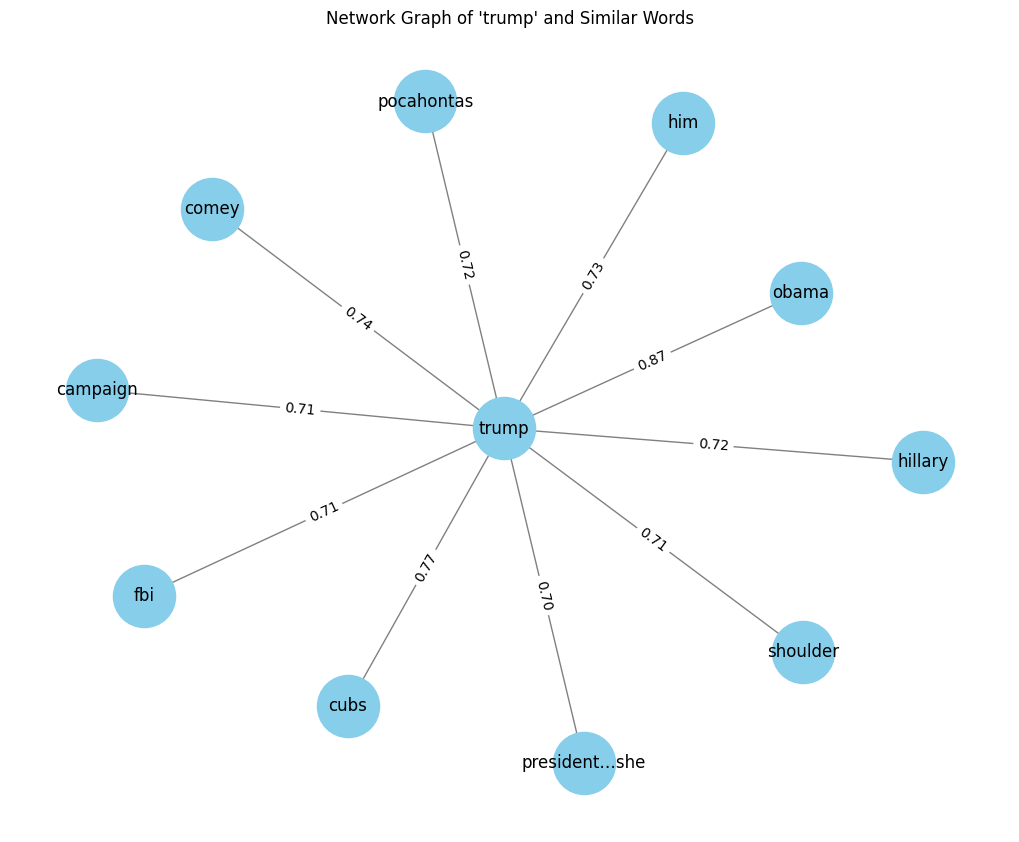

In [11]:
import networkx as nx

# Retrieve the most similar words to 'trump'
if 'trump' in w2v_model.wv:
    similar_words = w2v_model.wv.most_similar('trump', topn=10)

    # Create a graph
    G = nx.Graph()
    G.add_node('trump')  # Add the central word

    # Add nodes and edges for similar words
    for word, similarity in similar_words:
        G.add_node(word)
        G.add_edge('trump', word, weight=similarity)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # Positioning the nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})

    plt.title("Network Graph of 'trump' and Similar Words")
    plt.show()
else:
    print("\n'trump' not found in Word2Vec vocabulary.")
